Import needed stuff

In [2]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [3]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

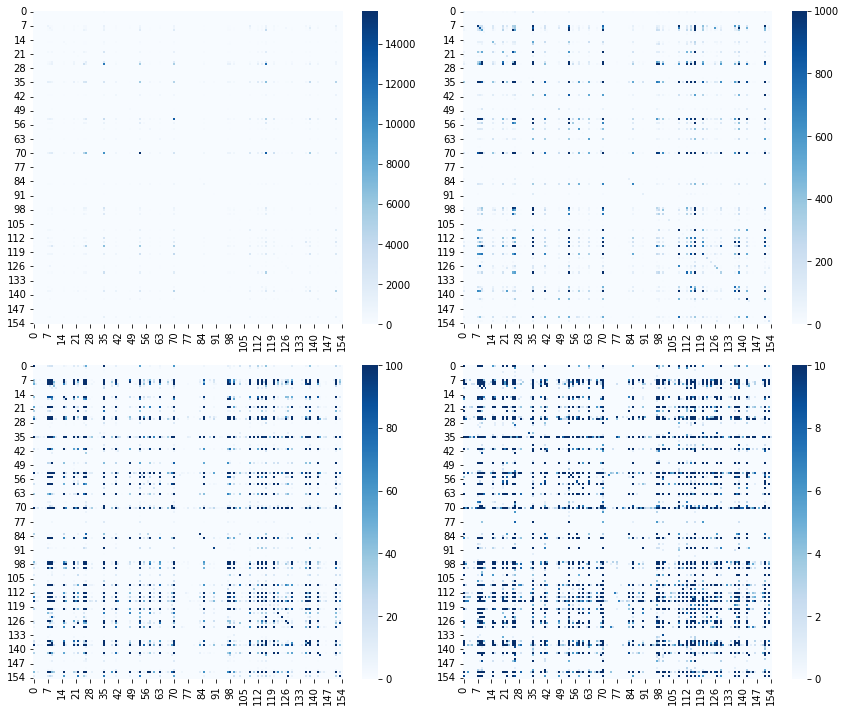

In [4]:
country_df = df[df[df.columns[10]]=='Learner']
country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha

country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

ns.visualize_adj(adj_matrix_crs)

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

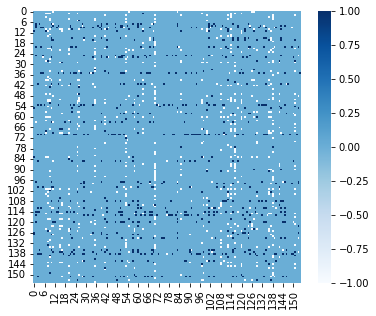

In [5]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [6]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 1


### Degree distribution

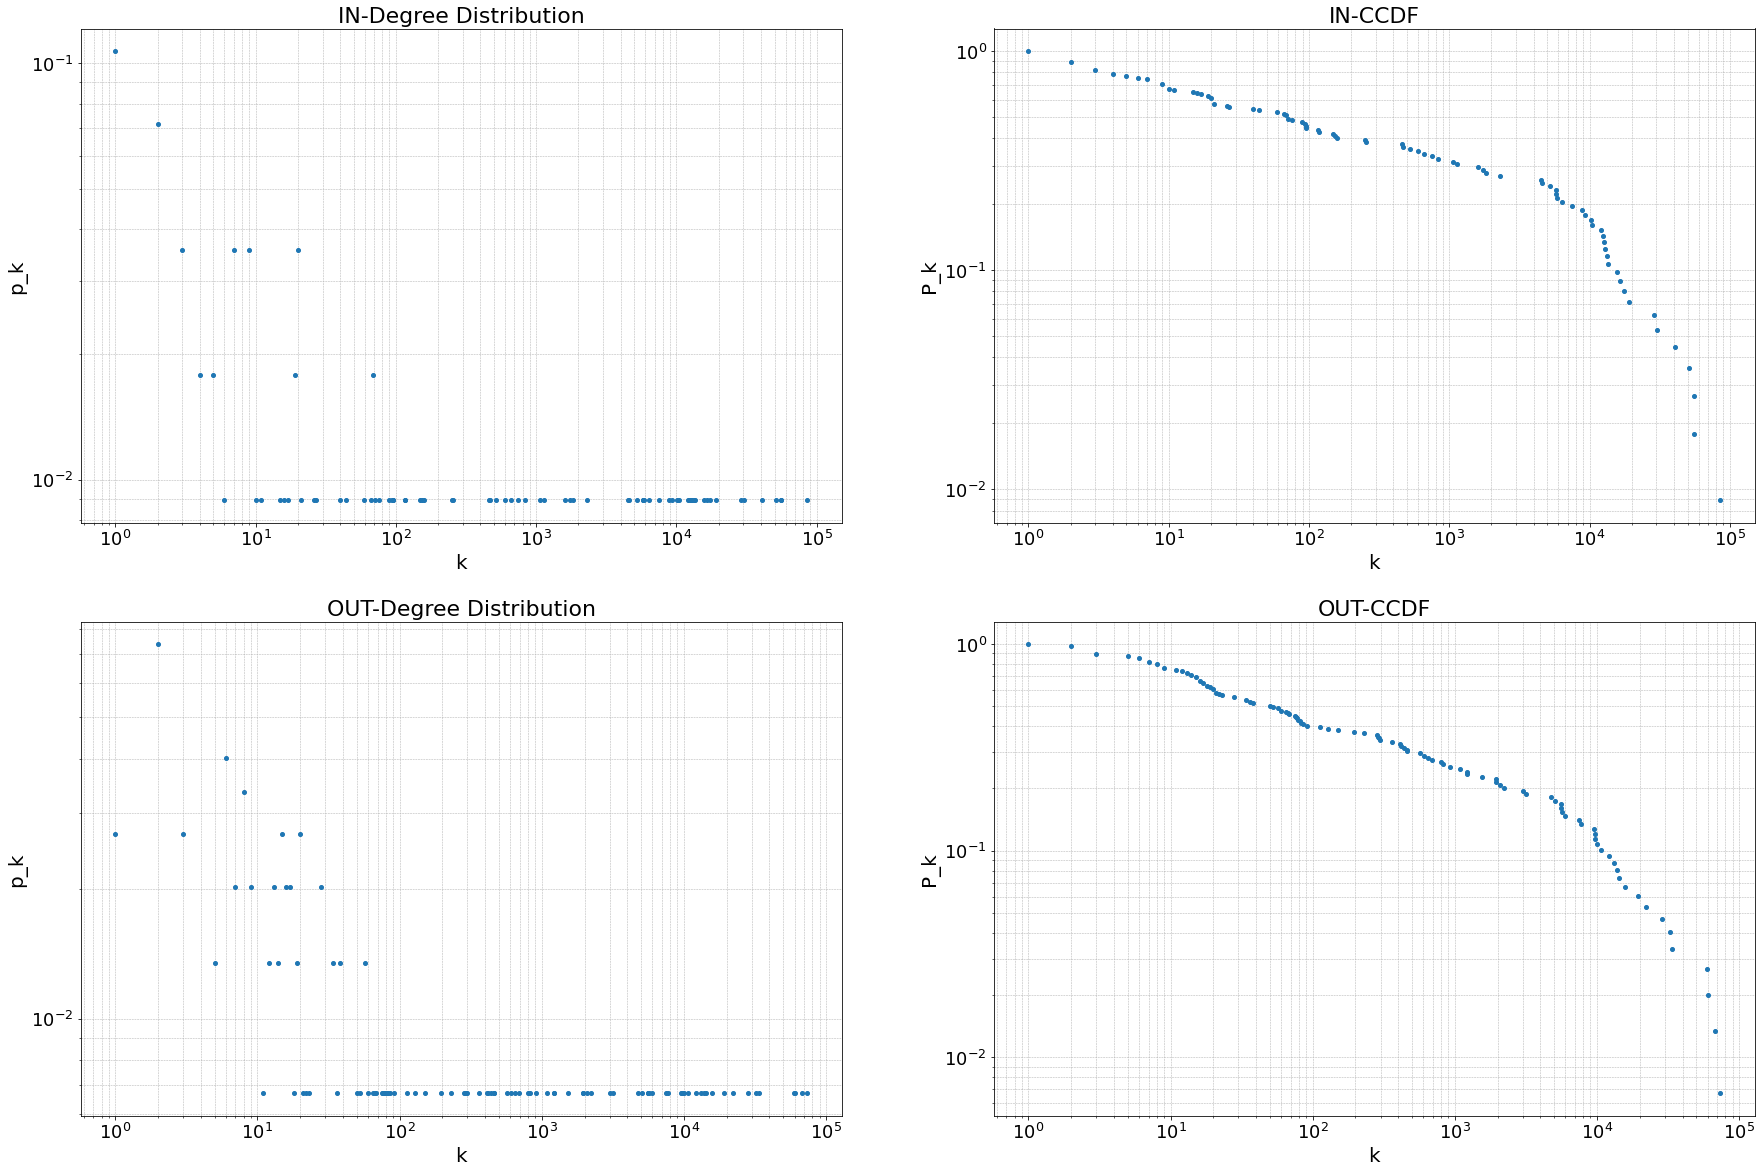

Top 10 for in degree


,Nodes,in degree
70,Spain,85255
26,UK,55556
35,Germany,55489
53,Italy,50912
116,France,40840
138,Poland,30154
120,Portugal,28984
25,Netherlands,19163
129,Ireland,17474
114,Czechia,16559


Top 10 for out degree


,Nodes,out degree
116,France,73481
35,Germany,67772
53,Italy,60222
70,Spain,59413
151,Turkey,33511
138,Poland,32388
26,UK,28448
25,Netherlands,22090
108,Romania,19294
120,Portugal,15750


In [7]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

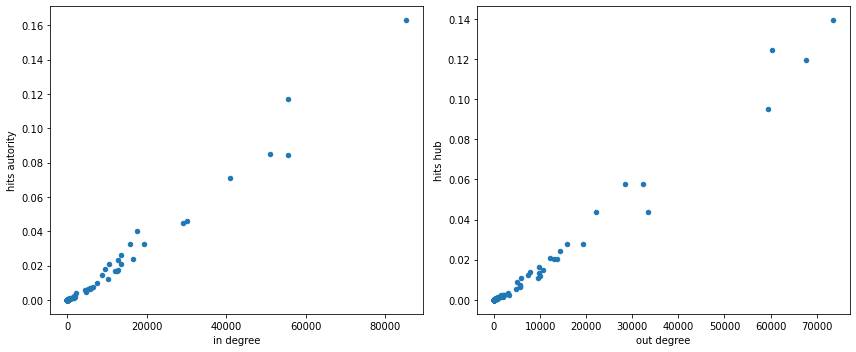

Top 10 for hits hub


,Nodes,hits hub
116,France,0.139283
53,Italy,0.124679
35,Germany,0.119749
70,Spain,0.094932
26,UK,0.057723
138,Poland,0.057705
25,Netherlands,0.043805
151,Turkey,0.043587
108,Romania,0.027973
120,Portugal,0.027626


Top 10 for hits autority


,Nodes,hits autority
70,Spain,0.162843
26,UK,0.117227
53,Italy,0.085113
35,Germany,0.084523
116,France,0.071154
138,Poland,0.046151
120,Portugal,0.044684
129,Ireland,0.040060
9,Belgium,0.032396
25,Netherlands,0.032326


In [8]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

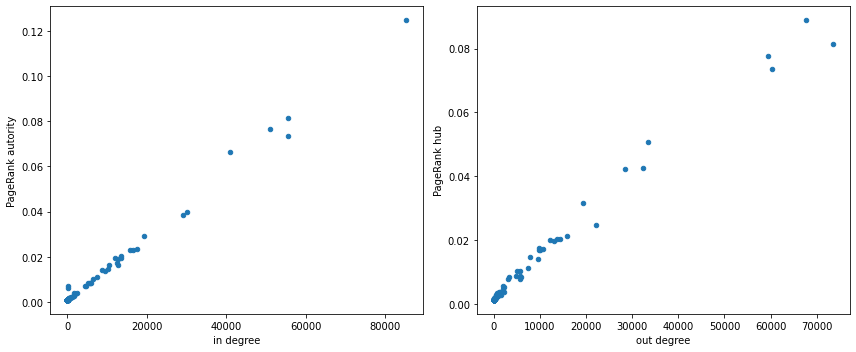

Top 10 for PageRank hub


,Nodes,PageRank hub
35,Germany,0.088870
116,France,0.081390
70,Spain,0.077764
53,Italy,0.073692
151,Turkey,0.050792
138,Poland,0.042699
26,UK,0.042150
108,Romania,0.031626
25,Netherlands,0.024640
120,Portugal,0.021385


Top 10 for PageRank autority


,Nodes,PageRank autority
70,Spain,0.124574
35,Germany,0.081602
53,Italy,0.076687
26,UK,0.073659
116,France,0.066544
138,Poland,0.040025
120,Portugal,0.038717
25,Netherlands,0.029240
129,Ireland,0.023405
114,Czechia,0.023160


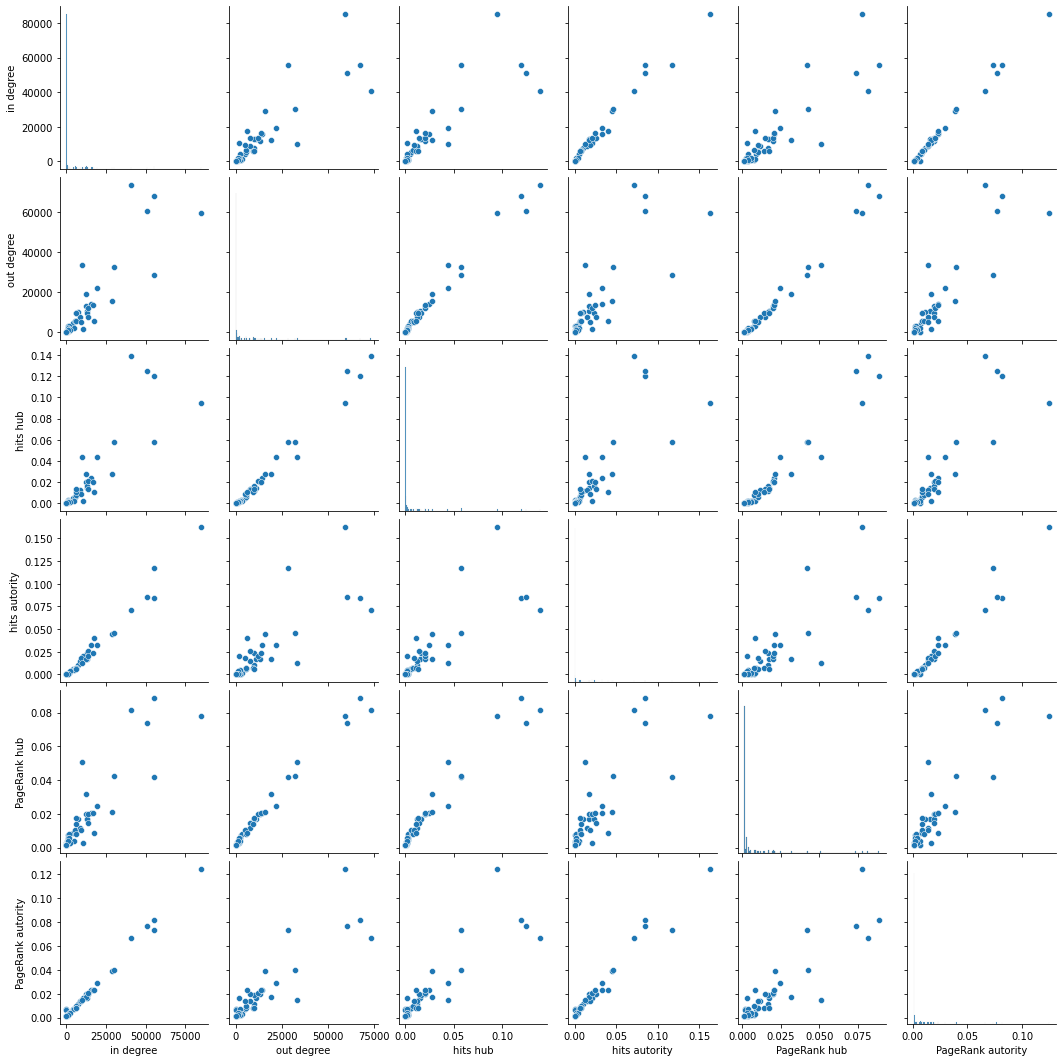

In [9]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')

sns.pairplot(scores)
plt.show()

In [10]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank autority')
scores.sort_index(inplace=True)

In [11]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank autority,PageRank autority position
70,Spain,85255,1,0.162843,1,0.124574,1
35,Germany,55489,3,0.084523,4,0.081602,2
53,Italy,50912,4,0.085113,3,0.076687,3
26,UK,55556,2,0.117227,2,0.073659,4
116,France,40840,5,0.071154,5,0.066544,5
138,Poland,30154,6,0.046151,6,0.040025,6
120,Portugal,28984,7,0.044684,7,0.038717,7
25,Netherlands,19163,8,0.032326,10,0.029240,8
129,Ireland,17474,9,0.040060,8,0.023405,9
114,Czechia,16559,10,0.023774,12,0.023160,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
35,Germany,67772,2,0.119749,3,0.088870,1
116,France,73481,1,0.139283,1,0.081390,2
70,Spain,59413,4,0.094932,4,0.077764,3
53,Italy,60222,3,0.124679,2,0.073692,4
151,Turkey,33511,5,0.043587,8,0.050792,5
138,Poland,32388,6,0.057705,6,0.042699,6
26,UK,28448,7,0.057723,5,0.042150,7
108,Romania,19294,9,0.027973,9,0.031626,8
25,Netherlands,22090,8,0.043805,7,0.024640,9
120,Portugal,15750,10,0.027626,10,0.021385,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

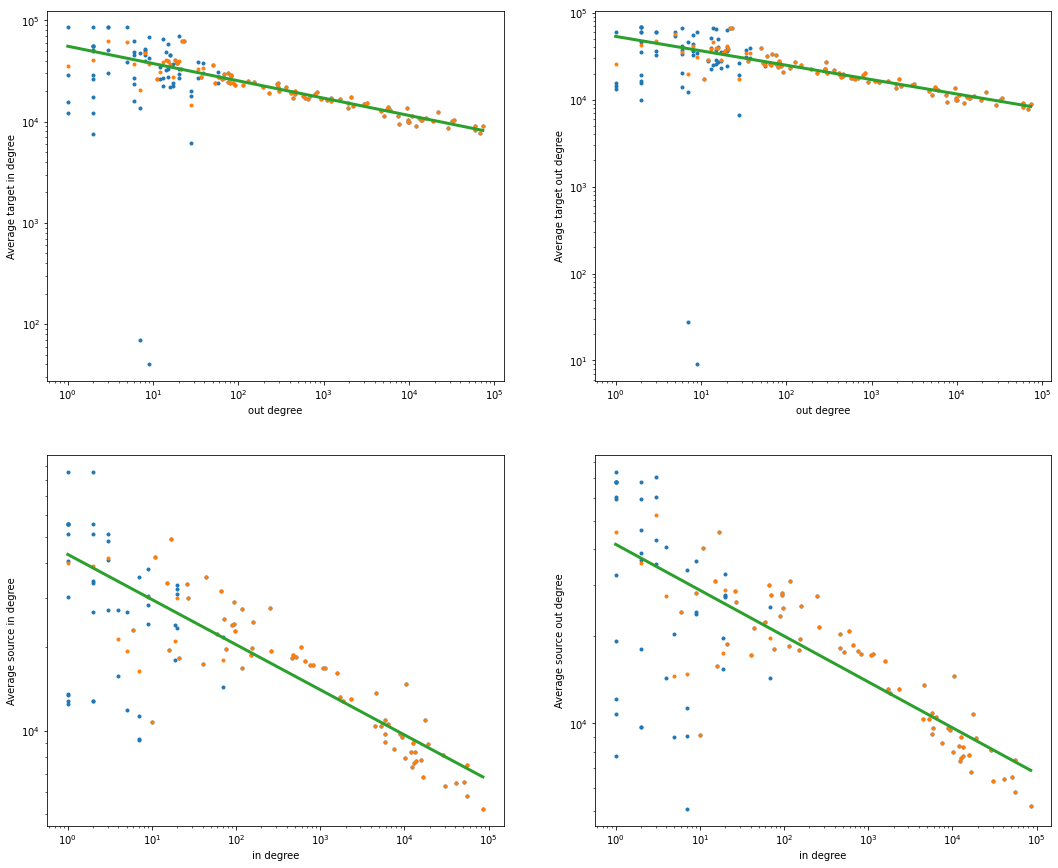

(-0.1709131474314809,
 -0.16566416781192514,
 -0.16258008251223896,
 -0.15802291954725187)

In [12]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

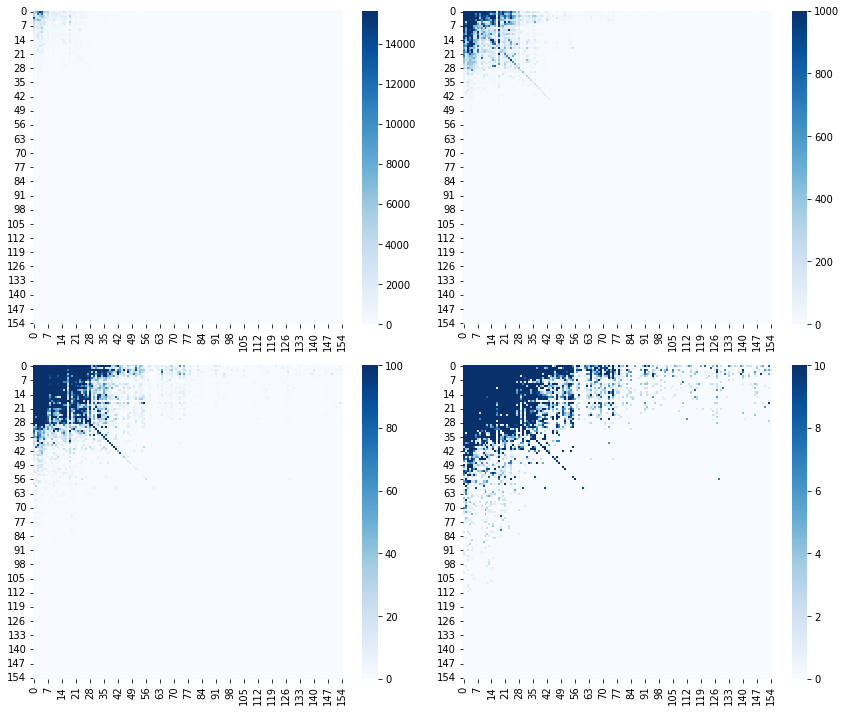

In [13]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

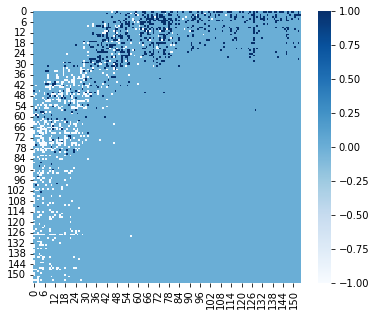

In [16]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [14]:
import networkx as nx
import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
2,Kyrgyzstan,0
4,Philippines,0
6,Mozambique,0
23,Syrian Arab Republic,0
24,Myanmar,0
...,...,...
141,Gibraltar,0
148,Belize,0
149,New Zealand,0
152,Uruguay,0


,Nodes,Community
0,Russian Federation,1
7,Hungary,1
11,Liechtenstein,1
12,Timor-Leste,1
15,Estonia,1
16,Iceland,1
18,Libya,1
22,Ukraine,1
33,Curaçao,1
44,Panama,1


,Nodes,Community
1,Chile,2
3,Kenya,2
8,EL,2
14,Tajikistan,2
19,Cabo Verde,2
20,Finland,2
21,Algeria,2
26,UK,2
30,Mauritius,2
37,Botswana,2


,Nodes,Community
5,"Tanzania, United Republic of",3
10,Tunisia,3
17,"Bolivia, Plurinational State of",3
29,India,3
39,Jordan,3
56,Greenland,3
75,El Salvador,3
97,Sweden,3
100,Norway,3
132,Lao People's Democratic Republic,3


,Nodes,Community
9,Belgium,4
13,Nicaragua,4
27,Rwanda,4
38,"Congo, The Democratic Republic of the",4
42,Lebanon,4
43,Aruba,4
102,French Polynesia,4


,Nodes,Community
54,Sint Maarten (Dutch part),5
67,China,5
73,Montserrat,5
74,Bangladesh,5
117,Afghanistan,5
151,Turkey,5
